In [10]:
from LNN import *

import h5py
from scipy.stats import lognorm
from scipy.spatial.distance import cosine

# matplotlib settings
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
def equalize(ax):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))

In [3]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax)

In [4]:
def struct_weight_plot_nonlinear_N(N_max, ks, v=None, s=1., typ=1, colors=colors,
                           sigmaM=1., sigmaC=1., ax=None, linestyle='-'):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    # iterate over scales
    for k_idx, k in enumerate(ks):
        Ns = np.arange(k, N_max, k)
        data = np.zeros(Ns.shape)
        for N_idx, N in enumerate(Ns):
            if typ==1:
                w=LNN.struct_weight_maker(N, k)
            else:
                w=LNN.struct_weight_maker(N, N/k)
            lnn = LNN(v=np.ones(N), w=w, 
                      sigmaM=sigmaM, sigmaC=sigmaC, nonlinearity='squared')
            data[N_idx] = lnn.FI_squared_nonlin(s)
        if typ==1:
            ax.plot(Ns, data, label=r'$k=%s$' %k, linewidth=4, color=colors[-k_idx], linestyle=linestyle)
        else:
            ax.plot(Ns, data, label=r'$k=N/%s$' %k, linewidth=4, color=colors[k_idx], linestyle=linestyle)
    ax.set_facecolor('white')
    ax.set_xlabel(r'$N$', fontsize = 30)
    ax.tick_params(labelsize=20)
    lgd = ax.legend(loc=2,
                    ncol=2,
                    facecolor='white', 
                    prop={'size' : 23}, 
                    handletextpad=0.4,
                    handlelength=1.2,
                    labelspacing=0.27,
                    columnspacing=0.50)
    lgd.get_frame().set_edgecolor('k')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    return ax

In [5]:
def struct_weight_plot_nonlinear_k(Ns, ks, v=None, s=1., colors=colors,
                           sigmaM=1., sigmaC=1., ax=None, linestyle='-'):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    data = np.zeros((Ns.size, ks.size))
    # iterate over scales
    for N_idx, N in enumerate(Ns):
        for k_idx, k in enumerate(ks):
            w=LNN.struct_weight_maker(N, k)
            lnn = LNN(v=np.ones(N), w=w, 
                      sigmaM=sigmaM, sigmaC=sigmaC, nonlinearity='squared')
            data[N_idx, k_idx] = lnn.FI_squared_nonlin(s)
        ax.plot(ks, data[N_idx, :], label=r'$N=%s$' %N, linewidth=4, color=colors[N_idx], linestyle=linestyle)
    ax.set_facecolor('white')
    ax.set_xlabel(r'$k_{\mathbf{w}}$', fontsize = 30)
    ax.tick_params(labelsize=20)
    #lgd = ax.legend(loc=3, bbox_to_anchor=(0., 1.02, 1., .102),
    #      fancybox=True, ncol=4, mode="expand", borderaxespad=0., prop={'size' : 15})
    lgd = ax.legend(
        facecolor='white', 
        prop={'size' : 25}, 
        handletextpad=0.4,
        handlelength=1.2,
        labelspacing=0.27,
        columnspacing=0.50)
    lgd.get_frame().set_edgecolor('k')
    for spine in ax.spines.values():
        spine.set_edgecolor('k')
    return ax

In [6]:
def plot_fisher_nonlinear_2d(N, ratios, ks, v=None, s=1., typ=1, colors=colors,
                            ax=None):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    if v is None:
        v = np.ones(N)
    fishers = np.zeros((ratios.size, ks.size))
    for ratio_idx, ratio in enumerate(ratios):
        sigmaM = 1
        sigmaC = ratio * sigmaM
        for k_idx, k in enumerate(ks):
            if typ==1:
                w=LNN.struct_weight_maker(N, k)
            else:
                w=LNN.struct_weight_maker(N, N/k)    
            lnn = LNN(v=np.ones(N), w=w, 
                      sigmaM=sigmaM, sigmaC=sigmaC, nonlinearity='squared')
            fishers[ratio_idx, k_idx] = lnn.FI_squared_nonlin(s)
        fishers[ratio_idx, :] = fishers[ratio_idx, :]/np.max(fishers[ratio_idx, :])
    ax.grid(False)
    img = ax.imshow(fishers.T, interpolation='spline36', vmin=0, vmax=1)
    ax.tick_params(labelsize=30)
    return img, fishers

In [7]:
def plot_max_weight_diversity(N, sigmaMs, sigmaCs, v=None, s=1., typ=1., colors=colors, ax=None):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    if v is None:
        v = np.ones(N)
    max_ks = np.zeros((sigmaMs.size, sigmaCs.size))
    for sigmaM_idx, sigmaM in enumerate(sigmaMs):
        for sigmaC_idx, sigmaC in enumerate(sigmaCs):
            fishers = np.zeros(10)
            for k_idx, k in enumerate(np.arange(1, 11)):
                if typ==1:
                    w=LNN.struct_weight_maker(N, k)
                else:
                    w=LNN.struct_weight_maker(N, N/k)    
                lnn = LNN(v=v, w=w, sigmaM=sigmaM, sigmaC=sigmaC, nonlinearity='squared')
                fishers[k_idx] = lnn.FI_squared_nonlin(s)
            max_ks[sigmaM_idx, sigmaC_idx] = np.argmax(fishers) + 1
    img = ax.imshow(max_ks, interpolation='spline36', vmin=1, vmax=10)
    ax.tick_params(labelsize=30)
    return img, max_ks

In [8]:
def plot_fisher_nonlinear_2d_u(N, ratios, mus, sigma, reps, v=None, s=1., typ=1, colors=colors,
                            ax=None):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    if v is None:
        v = np.ones(N)
    fishers = np.zeros((ratios.size, mus.size, reps))
    avg_fishers = np.zeros((ratios.size, mus.size))
    for ratio_idx, ratio in enumerate(ratios):
        sigmaM = 1
        sigmaC = ratio * sigmaM
        for mu_idx, mu in enumerate(mus):
            for rep in range(reps):
                v = np.ones(N)
                w = 1. + LNN.unstruct_weight_maker(N, 'lognormal', loc=mu, scale=sigma)
                lnn = LNN(v=v, w=w, nonlinearity='squared',
                     sigmaM=sigmaM, sigmaS=1, sigmaC=sigmaC)
                fishers[ratio_idx, mu_idx, rep] = lnn.FI_squared_nonlin(s)
            avg_fishers[ratio_idx, mu_idx] = np.mean(fishers[ratio_idx, mu_idx, :])
        avg_fishers[ratio_idx, :] = avg_fishers[ratio_idx, :]/np.max(avg_fishers[ratio_idx, :])
    ax.grid(False)
    img = ax.imshow(avg_fishers.T, interpolation='spline36', vmin=0, vmax=1)
    ax.tick_params(labelsize=20)
    return img

In [9]:
def plot_max_weight_diversity_u(N, reps, sigmaMs, sigmaCs, sigma=1., mus=np.linspace(-1, 2, 11), v=None, s=1., ax=None):
    # create plot
    if ax is None:
        fig = plt.figure(figsize = (10, 8))
        ax = fig.add_subplot(111)
    if v is None:
        v = np.ones(N)
    max_mus = np.zeros((sigmaMs.size, sigmaCs.size))
    for sigmaM_idx, sigmaM in enumerate(sigmaMs):
        for sigmaC_idx, sigmaC in enumerate(sigmaCs):
            fishers = np.zeros((11, reps))
            for mu_idx, mu in enumerate(mus):
                for rep in range(reps):
                    v = np.ones(N)
                    w = 1. + LNN.unstruct_weight_maker(N, 'lognormal', loc=mu, scale=sigma)
                    lnn = LNN(v=v, w=w, nonlinearity='squared',
                         sigmaM=sigmaM, sigmaS=1, sigmaC=sigmaC)
                    fishers[mu_idx, rep] = lnn.FI_squared_nonlin(s)
            max_mus[sigmaM_idx, sigmaC_idx] = mus[np.argmax(np.mean(fishers, axis=1)).ravel()[0]]
    img = ax.imshow(max_mus, interpolation='spline36', vmin=-1, vmax=2)
    ax.tick_params(labelsize=30)
    return img, max_mus

In [24]:
figure4d = h5py.File('figure4d.h5', 'r')['results'][:]
figure4e = h5py.File('figure4e.h5', 'r')['max_ks'][:]
figure4f = h5py.File('figure4f.h5', 'r')['results'][:]

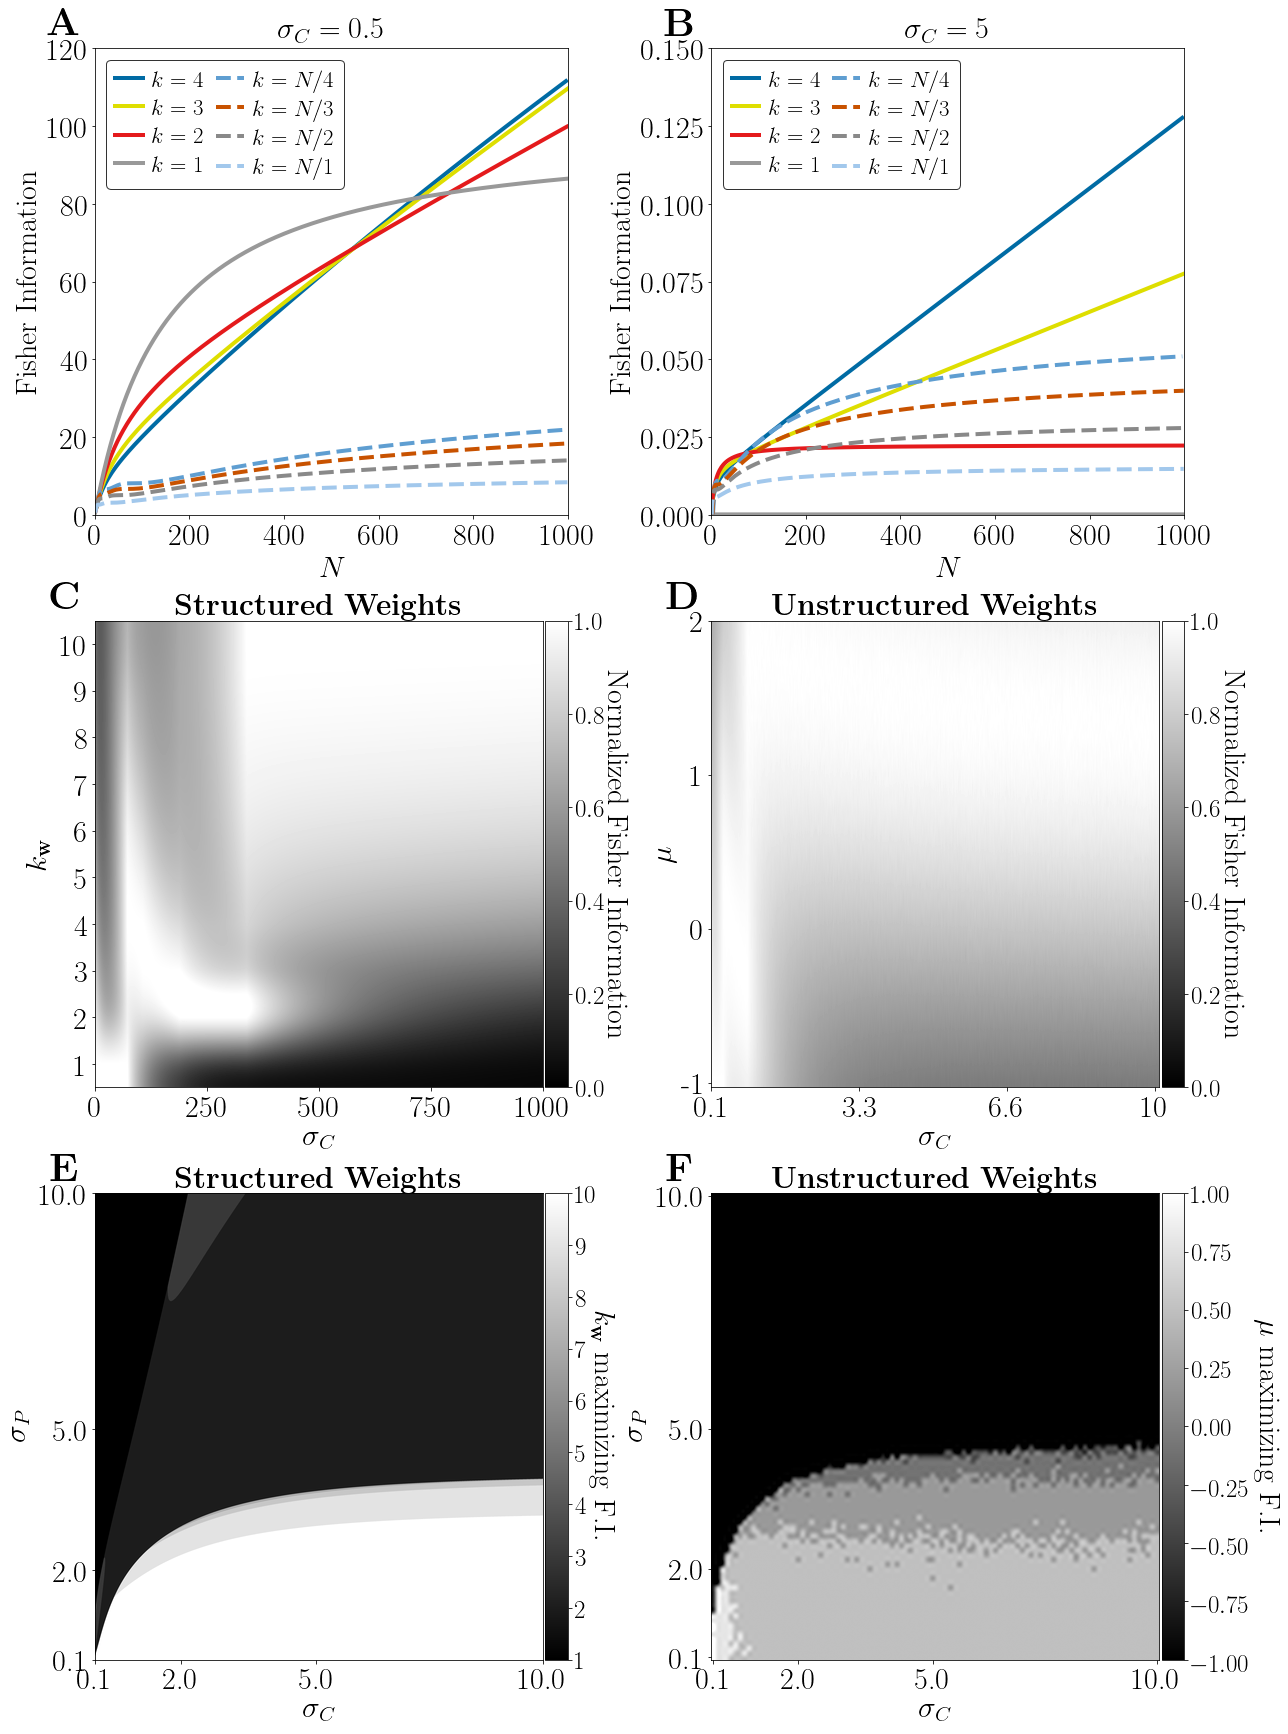

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(18,24))

# figure 4A
struct_weight_plot_nonlinear_N(1000, [4,3,2,1], typ=1, ax=axes[0,0], sigmaC=0.1, colors=['#006BA4', '#999999', '#e41a1c', '#dede00'])
struct_weight_plot_nonlinear_N(1000, [4,3,2,1], typ=2, ax=axes[0,0], linestyle='--', sigmaC=0.1, colors=['#5F9ED1', '#C85200', '#898989', '#A2C8EC'])
axes[0,0].set_xlim([0, 1000])
axes[0,0].set_ylim([0, 120])
axes[0,0].set_ylabel('Fisher Information', fontsize=30)
axes[0,0].text(x=-0.1, y=1.05, s=r'\textbf{A}', fontsize=40, verticalalignment='center', transform=axes[0,0].transAxes)
axes[0,0].set_title(r'$\sigma_C=0.5$', fontsize=30)
axes[0,0].tick_params(labelsize=30)

# figure 4B
struct_weight_plot_nonlinear_N(1000, [4,3,2,1], typ=1, ax=axes[0,1], sigmaC=10., colors=['#006BA4', '#999999', '#e41a1c', '#dede00'])
struct_weight_plot_nonlinear_N(1000, [4,3,2,1], typ=2, ax=axes[0,1], linestyle='--', sigmaC=10., colors=['#5F9ED1', '#C85200', '#898989', '#A2C8EC'])
axes[0,1].set_xlim([0, 1000])
axes[0,1].set_ylim([0, 0.15])
axes[0,1].set_ylabel('Fisher Information', fontsize=30)
axes[0,1].text(x=-0.1, y=1.05, s=r'\textbf{B}', fontsize=40, verticalalignment='center', transform=axes[0, 1].transAxes)
axes[0,1].set_title(r'$\sigma_C=5$', fontsize=30)
axes[0,1].tick_params(labelsize=30)

# figure 4C
ratios = np.linspace(0.01, 1, 1000)
ks = np.arange(1, 11)
img, fishers = plot_fisher_nonlinear_2d(1000, ratios, ks, s=1, typ=1, ax=axes[1,0])
axes[1,0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axes[1,0].set_yticklabels(np.arange(1, 11))
axes[1,0].tick_params(labelsize=30)
axes[1,0].set_xlabel(r'$\sigma_C$', fontsize=30)
axes[1,0].set_ylabel(r'$k_{\mathbf{w}}$', fontsize=30)
axes[1,0].text(x=-0.1, y=1.05, s=r'\textbf{C}', fontsize=40, verticalalignment='center', transform=axes[1, 0].transAxes)
axes[1,0].set_aspect('auto')
divider = make_axes_locatable(axes[1, 0])
axes[1, 0].set_title(r'\textbf{Structured Weights}', fontsize=30)
cax = divider.append_axes("right", size="5%", pad=0.04)
cb = plt.colorbar(img, fraction=0.046, pad=0.04, cax=cax)
cb.ax.set_ylabel(r'Normalized Fisher Information', fontsize=30, rotation=270, labelpad=25)
cb.ax.tick_params(labelsize=25) 

# figure 4D
ratios = np.linspace(0.01, 1, 1000)
mus=np.linspace(-1, 1, 50)
img4d = axes[1, 1].imshow(figure4d.T, vmin=0, vmax=1, interpolation='spline36')
axes[1, 1].set_xlabel(r'$\sigma_C$', fontsize=30)
axes[1, 1].set_ylabel(r'$\mu$', fontsize=30)
axes[1, 1].set_title(r'\textbf{Unstructured Weights}', fontsize=30)
axes[1, 1].tick_params(labelsize=30)
axes[1, 1].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axes[1, 1].set_yticklabels(np.arange(1, 11))
axes[1, 1].set_yticks(mus.size * np.array([0, 0.33, 0.66, 0.99]))
axes[1, 1].set_yticklabels([-1, 0, 1, 2])
axes[1, 1].set_xticks(ratios.size * np.array([0, 0.33, 0.66, 0.99]))
axes[1, 1].set_xticklabels([0.1, 3.3, 6.6, 10])
axes
axes[1, 1].text(x=-0.1, y=1.05, s=r'\textbf{D}', fontsize=40, verticalalignment='center', transform=axes[1, 1].transAxes)
# handle colorbar
axes[1,1].set_aspect('auto')
divider = make_axes_locatable(axes[1, 1])
cax = divider.append_axes("right", size="5%", pad=0.04)
cb = plt.colorbar(img4d, fraction=0.046, pad=0.04, cax=cax)
cb.ax.set_ylabel(r'Normalized Fisher Information', fontsize=30, rotation=270, labelpad=25)
cb.ax.tick_params(labelsize=25) 

# figure 4E
sigmaMs = np.linspace(0.1, 10, 5000)
sigmaCs = np.linspace(0.1, 10, 5000)
img4e = axes[2, 0].imshow(figure4e, vmin=1, vmax=10, interpolation='spline36')
# handle ticks and labels
ticks_labels = np.array([0.1, 2.0, 5.0, 10])
ticks = [min(range(len(sigmaMs)), key=lambda i: abs(sigmaMs[i]-label)) for label in ticks_labels]
axes[2,0].set_xticks(ticks)
axes[2,0].set_xticklabels(ticks_labels)
axes[2,0].set_yticks(ticks)
axes[2,0].set_yticklabels(ticks_labels)
# axes labels
axes[2,0].set_xlabel(r'$\sigma_C$', fontsize=30)
axes[2,0].set_ylabel(r'$\sigma_P$', fontsize=30)
axes[2,0].set_title(r'\textbf{Structured Weights}', fontsize=30)
axes[2,0].tick_params(labelsize=30)
# handle colorbar
axes[2,0].set_aspect('auto')
divider = make_axes_locatable(axes[2, 0])
cax = divider.append_axes("right", size="5%", pad=0.04)
cb = plt.colorbar(img4e, fraction=0.046, pad=0.04, cax=cax)
cb.ax.set_ylabel(r'$k_{\mathbf{w}}$ maximizing F.I.', fontsize=30, rotation=270, labelpad=15)
cb.ax.tick_params(labelsize=25) 
# plot label
axes[2, 0].text(x=-0.1, y=1.05, s=r'\textbf{E}', fontsize=40, verticalalignment='center', transform=axes[2, 0].transAxes)

# figure 4F
sigmaMs = np.linspace(0.1, 10, 100)
sigmaCs = np.linspace(0.1, 10, 100)
img4f = axes[2,1].imshow(figure4f, interpolation='spline36', vmin=-1, vmax=1)
# handle ticks and labels
ticks_labels = np.array([0.1, 2.0, 5.0, 10])
ticks = [min(range(len(sigmaMs)), key=lambda i: abs(sigmaMs[i]-label)) for label in ticks_labels]
axes[2,1].set_xticks(ticks)
axes[2,1].set_xticklabels(ticks_labels)
axes[2,1].set_yticks(ticks)
axes[2,1].set_yticklabels(ticks_labels)
# axes labels
axes[2,1].set_xlabel(r'$\sigma_C$', fontsize=30)
axes[2,1].set_ylabel(r'$\sigma_P$', fontsize=30)
axes[2,1].set_title(r'\textbf{Unstructured Weights}', fontsize=30)
axes[2,1].tick_params(labelsize=30)
# handle colorbar
axes[2,1].set_aspect('auto')
divider = make_axes_locatable(axes[2, 1])
cax = divider.append_axes("right", size="5%", pad=0.04)
cb = plt.colorbar(img4f, fraction=0.046, pad=0.04, cax=cax)
cb.ax.set_ylabel(r'$\mu$ maximizing F.I.', fontsize=30, rotation=270, labelpad=30)
cb.ax.tick_params(labelsize=25) 
# plot label
axes[2, 1].text(x=-0.1, y=1.05, s=r'\textbf{F}', fontsize=40, verticalalignment='center', transform=axes[2, 1].transAxes)



plt.tight_layout(rect=[0, 0., 1., 1.])
plt.savefig('figure6.pdf', bbox_inches='tight')